# VAE Debug - whole model test KL Loss

In [104]:
## Using vae_v3.py

import tensorflow as tf
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd



### DATA PREPARATION
gene_matrix_array = np.load("gene_matrix_list.npy")
rna_expression_df = pd.read_csv("rna_expression_list.csv")

# Check order of genes in both files is the same
assert gene_matrix_array.shape[0] == len(
    rna_expression_df
), "Mismatch in number of genes"

# Separate modification types
dnam_features = gene_matrix_array[:, :, 0]
h3k9me3_features = gene_matrix_array[:, :, 1]
h3k27me3_features = gene_matrix_array[:, :, 2]
rna_expression = (rna_expression_df["expression"].values > 0).astype(
    int
)  # convert expression to binary
expression_values = rna_expression.reshape(-1, 1)  # Shape (58780, 1)

# Concatenate all features, including expression, to make 1D
X = np.concatenate(
    (dnam_features, h3k9me3_features, h3k27me3_features, expression_values), axis=1
)


balanced = True

if balanced: 
    ### BALANCING THE DATASET (expression)
    # Separate into two groups: those with expression 0 and those with expression 1
    X_zeros = X[X[:, -1] == 0]  # expression 0
    X_ones = X[X[:, -1] == 1]  # expression 1

    # Find the number of ones (minority class) and downsample the zeros (majority class)
    n_ones = len(X_ones)
    X_zeros_downsampled = X_zeros[np.random.choice(X_zeros.shape[0], n_ones, replace=False)]

    # concat and shuffle the balanced dataset
    X_balanced = np.concatenate([X_zeros_downsampled, X_ones], axis=0)
    np.random.shuffle(X_balanced)
    X = X_balanced


# Split into training, validation, and testing (80% training, 20% testing)
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

In [6]:
test = np.sum(X, axis = 1)
print(np.mean(test))

307.6793977543382


In [301]:


### VAE
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        kl_loss = -0.5 * tf.reduce_mean(
            1 + log_var - tf.exp(log_var) - tf.square(mean),
            axis=-1,
        )
        self.add_loss(kl_loss * 0.000001)


        return tf.random.normal(tf.shape(log_var)) * tf.exp(log_var / 2) + mean


# class KLDivergenceLayer(tf.keras.layers.Layer):
#     def call(self, inputs):
#         codings_mean, codings_log_var = inputs
#         kl_loss = -0.5 * tf.reduce_sum(
#             1 + codings_log_var - tf.exp(codings_log_var) - tf.square(codings_mean),
#             axis=-1,
#         )
#         self.add_loss(tf.reduce_mean(kl_loss)) #/ 12001.0)
#         return inputs


codings_size = 300
# ### ORIGINAL MODEL
# # ENCODER
inputs = tf.keras.layers.Input(shape=[12001])
x = tf.keras.layers.Dense(1280, activation="relu")(inputs)  # Increase size
x = tf.keras.layers.Dense(1024, activation="relu")(x)  # Increase size
x = tf.keras.layers.Dense(768, activation="relu")(x) # changing layer sizes
x = tf.keras.layers.Dense(512, activation="relu")(x)
#x = tf.keras.layers.Dense(256, activation="relu")(x)
codings_mean = tf.keras.layers.Dense(codings_size)(x)  # mean
codings_log_var = tf.keras.layers.Dense(codings_size)(x)  # log_var
codings = Sampling()([codings_mean, codings_log_var])  # KL Loss added here


# KL Divergence Layer
# codings_mean, codings_log_var = KLDivergenceLayer()([codings_mean, codings_log_var])

# define VAE
variational_encoder = tf.keras.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings]
)

# DECODER
decoder_inputs = tf.keras.layers.Input(shape=[codings_size])
#x = tf.keras.layers.Dense(256, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(512, activation="relu")(decoder_inputs)
x = tf.keras.layers.Dense(768, activation="relu")(x)
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(0.3)(x)  # Dropout to regularize
x = tf.keras.layers.Dense(1024, activation="relu")(x)  # Add another layer
#x = tf.keras.layers.BatchNormalization()(x)
#x = tf.keras.layers.Dropout(0.3)(x)  # Dropout to regularize
x = tf.keras.layers.Dense(1280, activation="relu")(x)  # Add another layer
x = tf.keras.layers.Dense(12001, activation="sigmoid")(x)  # Output layer for binary data


# Output match original input
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[x])
_, _, codings = variational_encoder(inputs)  # Generate codings
reconstructions = variational_decoder(codings)  # Decode codings

# Define the VAE model
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])


# class KLTrackingCallback(tf.keras.callbacks.Callback):
#     def on_epoch_end(self, epoch, logs=None):
#         # Total loss and reconstruction loss are logged automatically
#         total_loss = logs.get('loss')
#         recon_loss = logs.get(focal_loss)  # Since you're using binary crossentropy
#         if total_loss and recon_loss:
#             # KL Loss is the difference between total loss and reconstruction loss
#             kl_loss = total_loss - recon_loss
#             print(f"Epoch {epoch + 1}: KL Loss = {kl_loss:.4f}")


# compile (reconstruction loss added here)
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001)
focal_loss = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.25, gamma=2.0, from_logits=False)
variational_ae.compile(
    loss= focal_loss,
    optimizer=optimizer,
    metrics=['binary_crossentropy', focal_loss],
)

# Adding early stopping
# kl_tracking_callback = KLTrackingCallback()
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)



In [302]:
# train using train and valid set
history = variational_ae.fit(
    X_train,
    X_train,
    epochs=10,
    batch_size=128,
    validation_data=(X_val, X_val),
    callbacks=[early_stopping],#kl_tracking_callback],
)


Epoch 1/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 59s 201ms/step - binary_crossentropy: 0.2180 - binary_focal_crossentropy: 0.0355 - loss: 0.0355 - val_binary_crossentropy: 0.1448 - val_binary_focal_crossentropy: 0.0191 - val_loss: 0.0191
Epoch 2/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 54s 194ms/step - binary_crossentropy: 0.1414 - binary_focal_crossentropy: 0.0192 - loss: 0.0192 - val_binary_crossentropy: 0.1326 - val_binary_focal_crossentropy: 0.0182 - val_loss: 0.0182
Epoch 3/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 54s 196ms/step - binary_crossentropy: 0.1333 - binary_focal_crossentropy: 0.0183 - loss: 0.0183 - val_binary_crossentropy: 0.1340 - val_binary_focal_crossentropy: 0.0175 - val_loss: 0.0175
Epoch 4/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 55s 197ms/step - binary_crossentropy: 0.1283 - binary_focal_crossentropy: 0.0176 - loss: 0.0176 - val_binary_crossentropy: 0.1219 - val_binary_focal_crossentropy: 0.0167 - val_loss: 0.0168
Epoch 5/10
277/277 ━━━━━━━━━━━━━━━━━━━━ 56s 203ms/step - binary_crossentropy: 0.1238

**Experimenting with altering coding size**

`coding_size` = 50
`learning_rate` = 0.001
`optimizer` = Adam

- KL Loss: 0.0055, 0.0001, 0.0000

`coding_size` = 500
`learning_rate` = 0.001
`optimizer` = Adam

- KL Loss: 0.0005, 0.0000

`coding_size` = 10
`learning_rate` = 0.001
`optimizer` = Adam

- KL Loss: 0.0322, 0.0000

**Experimenting with altering Learning rate**
`coding_size` = 50
`learning_rate` = 0.001
`optimizer` = Adam

- KL Loss: 0.0055, 0.0001, 0.0000

`coding_size` = 50
`learning_rate` = 0.1
`optimizer` = Adam

- KL Loss: 0.0012, 0.0000


**Experimenting with altering beta value for weighted KL Loss**

`coding_size` = 50
`learning_rate` = 0.001
`optimizer` = Adam
`beta` = 0.5

- KL Loss: 0.0053, 0.0000

`coding_size` = 50
`learning_rate` = 0.001
`optimizer` = Adam
`beta` = 2

- KL Loss: 0.0099, 0.0000


In [303]:
kl_train = np.array(history.history["loss"]) - np.array(history.history["binary_focal_crossentropy"])
kl_val = np.array(history.history["val_loss"]) - np.array(history.history["val_binary_focal_crossentropy"])
print(kl_train)

[2.77664512e-05 3.61613929e-05 4.04771417e-05 4.74508852e-05
 5.21317124e-05 5.23366034e-05 5.24166971e-05 5.19081950e-05
 5.45140356e-05 5.65499067e-05]


In [304]:
# import matplotlib.pyplot as plt

# fig, axs = plt.subplots(1, 3, figsize=(14, 6))

# # Plot training and validation loss (Total Loss)
# axs[0].plot(history.history["loss"], label="Training Loss")
# axs[0].plot(history.history["val_loss"], label="Validation Loss")
# axs[0].set_xlabel("Epochs")
# axs[0].set_ylabel("Total Loss")
# axs[0].legend()
# axs[0].set_title("Training and Validation Total Loss")

# # Plot training and validation KL Divergence
# axs[1].plot(history.history["binary_focal_crossentropy"], label="Training Recon Loss")
# axs[1].plot(history.history["val_binary_focal_crossentropy"], label="Validation Recon Loss")
# axs[1].set_xlabel("Epochs")
# axs[1].set_ylabel("Recon Loss")
# axs[1].legend()
# axs[1].set_title("Training and Validation Recon Loss (Focal Binary Cross Entropy)")

# axs[2].plot(kl_train, label="Training Recon Loss")
# axs[2].plot(kl_val, label="Validation Recon Loss")
# axs[2].set_xlabel("Epochs")
# axs[2].set_ylabel("KL Loss")
# axs[2].legend()
# axs[2].set_title("Training and Validation KL Loss (0.001)")

# # Adjust layout and save the figure
# plt.tight_layout()
# #plt.savefig("vae_v1_total_and_kl_loss_50.png")
# plt.show()


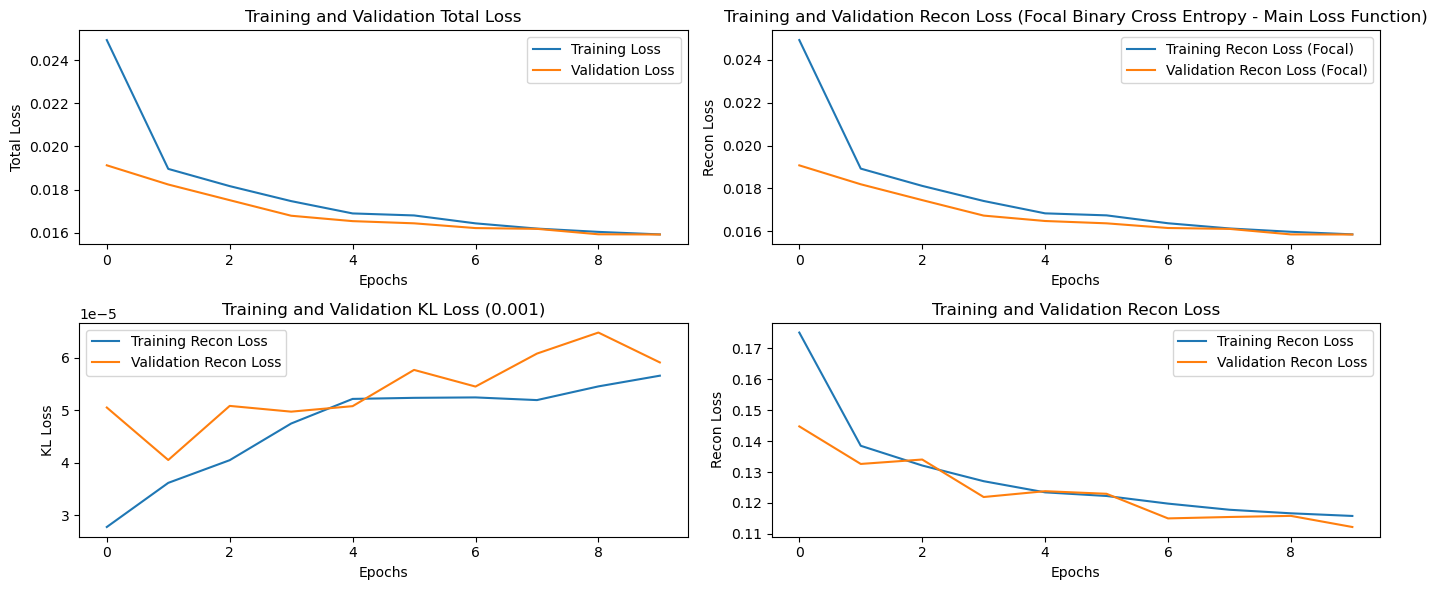

In [305]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(14, 6))

# Plot training and validation loss (Total Loss)
axs[0,0].plot(history.history["loss"], label="Training Loss")
axs[0,0].plot(history.history["val_loss"], label="Validation Loss")
axs[0,0].set_xlabel("Epochs")
axs[0,0].set_ylabel("Total Loss")
axs[0,0].legend()
axs[0,0].set_title("Training and Validation Total Loss")

# Plot training and validation KL Divergence
axs[0,1].plot(history.history["binary_focal_crossentropy"], label="Training Recon Loss (Focal)")
axs[0,1].plot(history.history["val_binary_focal_crossentropy"], label="Validation Recon Loss (Focal)")
axs[0,1].set_xlabel("Epochs")
axs[0,1].set_ylabel("Recon Loss")
axs[0,1].legend()
axs[0,1].set_title("Training and Validation Recon Loss (Focal Binary Cross Entropy - Main Loss Function)")

axs[1,0].plot(kl_train, label="Training Recon Loss")
axs[1,0].plot(kl_val, label="Validation Recon Loss")
axs[1,0].set_xlabel("Epochs")
axs[1,0].set_ylabel("KL Loss")
axs[1,0].legend()
axs[1,0].set_title("Training and Validation KL Loss (0.001)")

axs[1,1].plot(history.history["binary_crossentropy"], label="Training Recon Loss")
axs[1,1].plot(history.history["val_binary_crossentropy"], label="Validation Recon Loss")
axs[1,1].set_xlabel("Epochs")
axs[1,1].set_ylabel("Recon Loss")
axs[1,1].legend()
axs[1,1].set_title("Training and Validation Recon Loss")




# Adjust layout and save the figure
plt.tight_layout()
#plt.savefig("vae_v1_total_and_kl_loss_50.png")
plt.show()

In [306]:
coding_mean, coding_log_var, latent_codings = variational_encoder.predict(X_val) 

277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


In [307]:
latent_codings = np.array(latent_codings)

print(latent_codings.shape)
print(X_val.shape)

(8856, 300)
(8856, 12001)


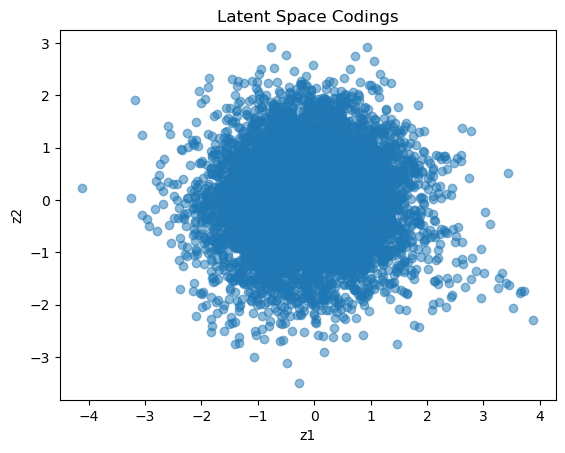

In [308]:
import numpy as np 
latent_codings = np.array(latent_codings)

# check the first 2 dimensions of the latent codings - should be centered aroun [0,0]
plt.scatter(latent_codings[:, 0], latent_codings[:, 1], alpha=0.5)
plt.title('Latent Space Codings')
plt.xlabel('z1')
plt.ylabel('z2')
plt.show()

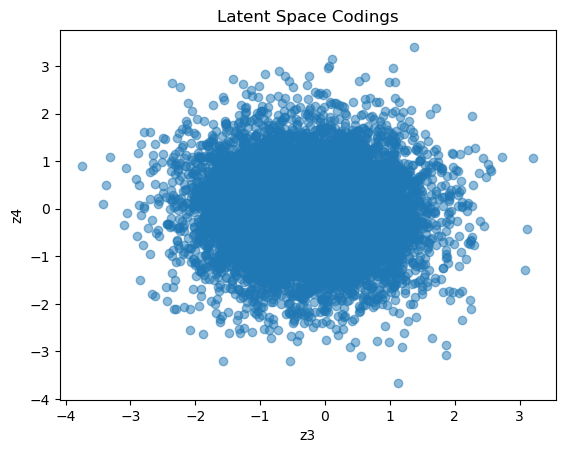

In [309]:
# check the 3rd & 4th dimensions of the latent codings - should be centered aroun [0,0]
plt.scatter(latent_codings[:, 2], latent_codings[:, 3], alpha=0.5)
plt.title('Latent Space Codings')
plt.xlabel('z3')
plt.ylabel('z4')
plt.show()

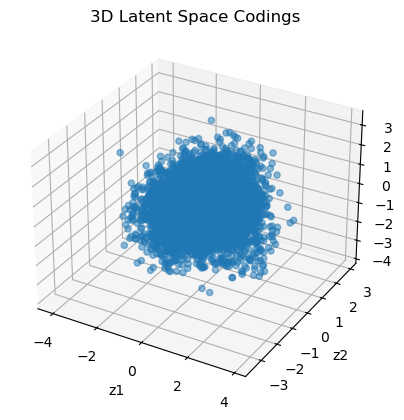

In [310]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#  first three dimensions of the latent space
ax.scatter(latent_codings[:, 0], latent_codings[:, 1], latent_codings[:, 2], alpha=0.5)

ax.set_xlabel('z1')
ax.set_ylabel('z2')
ax.set_zlabel('z3')

plt.title('3D Latent Space Codings')
plt.show()


Seems to be normally distributed

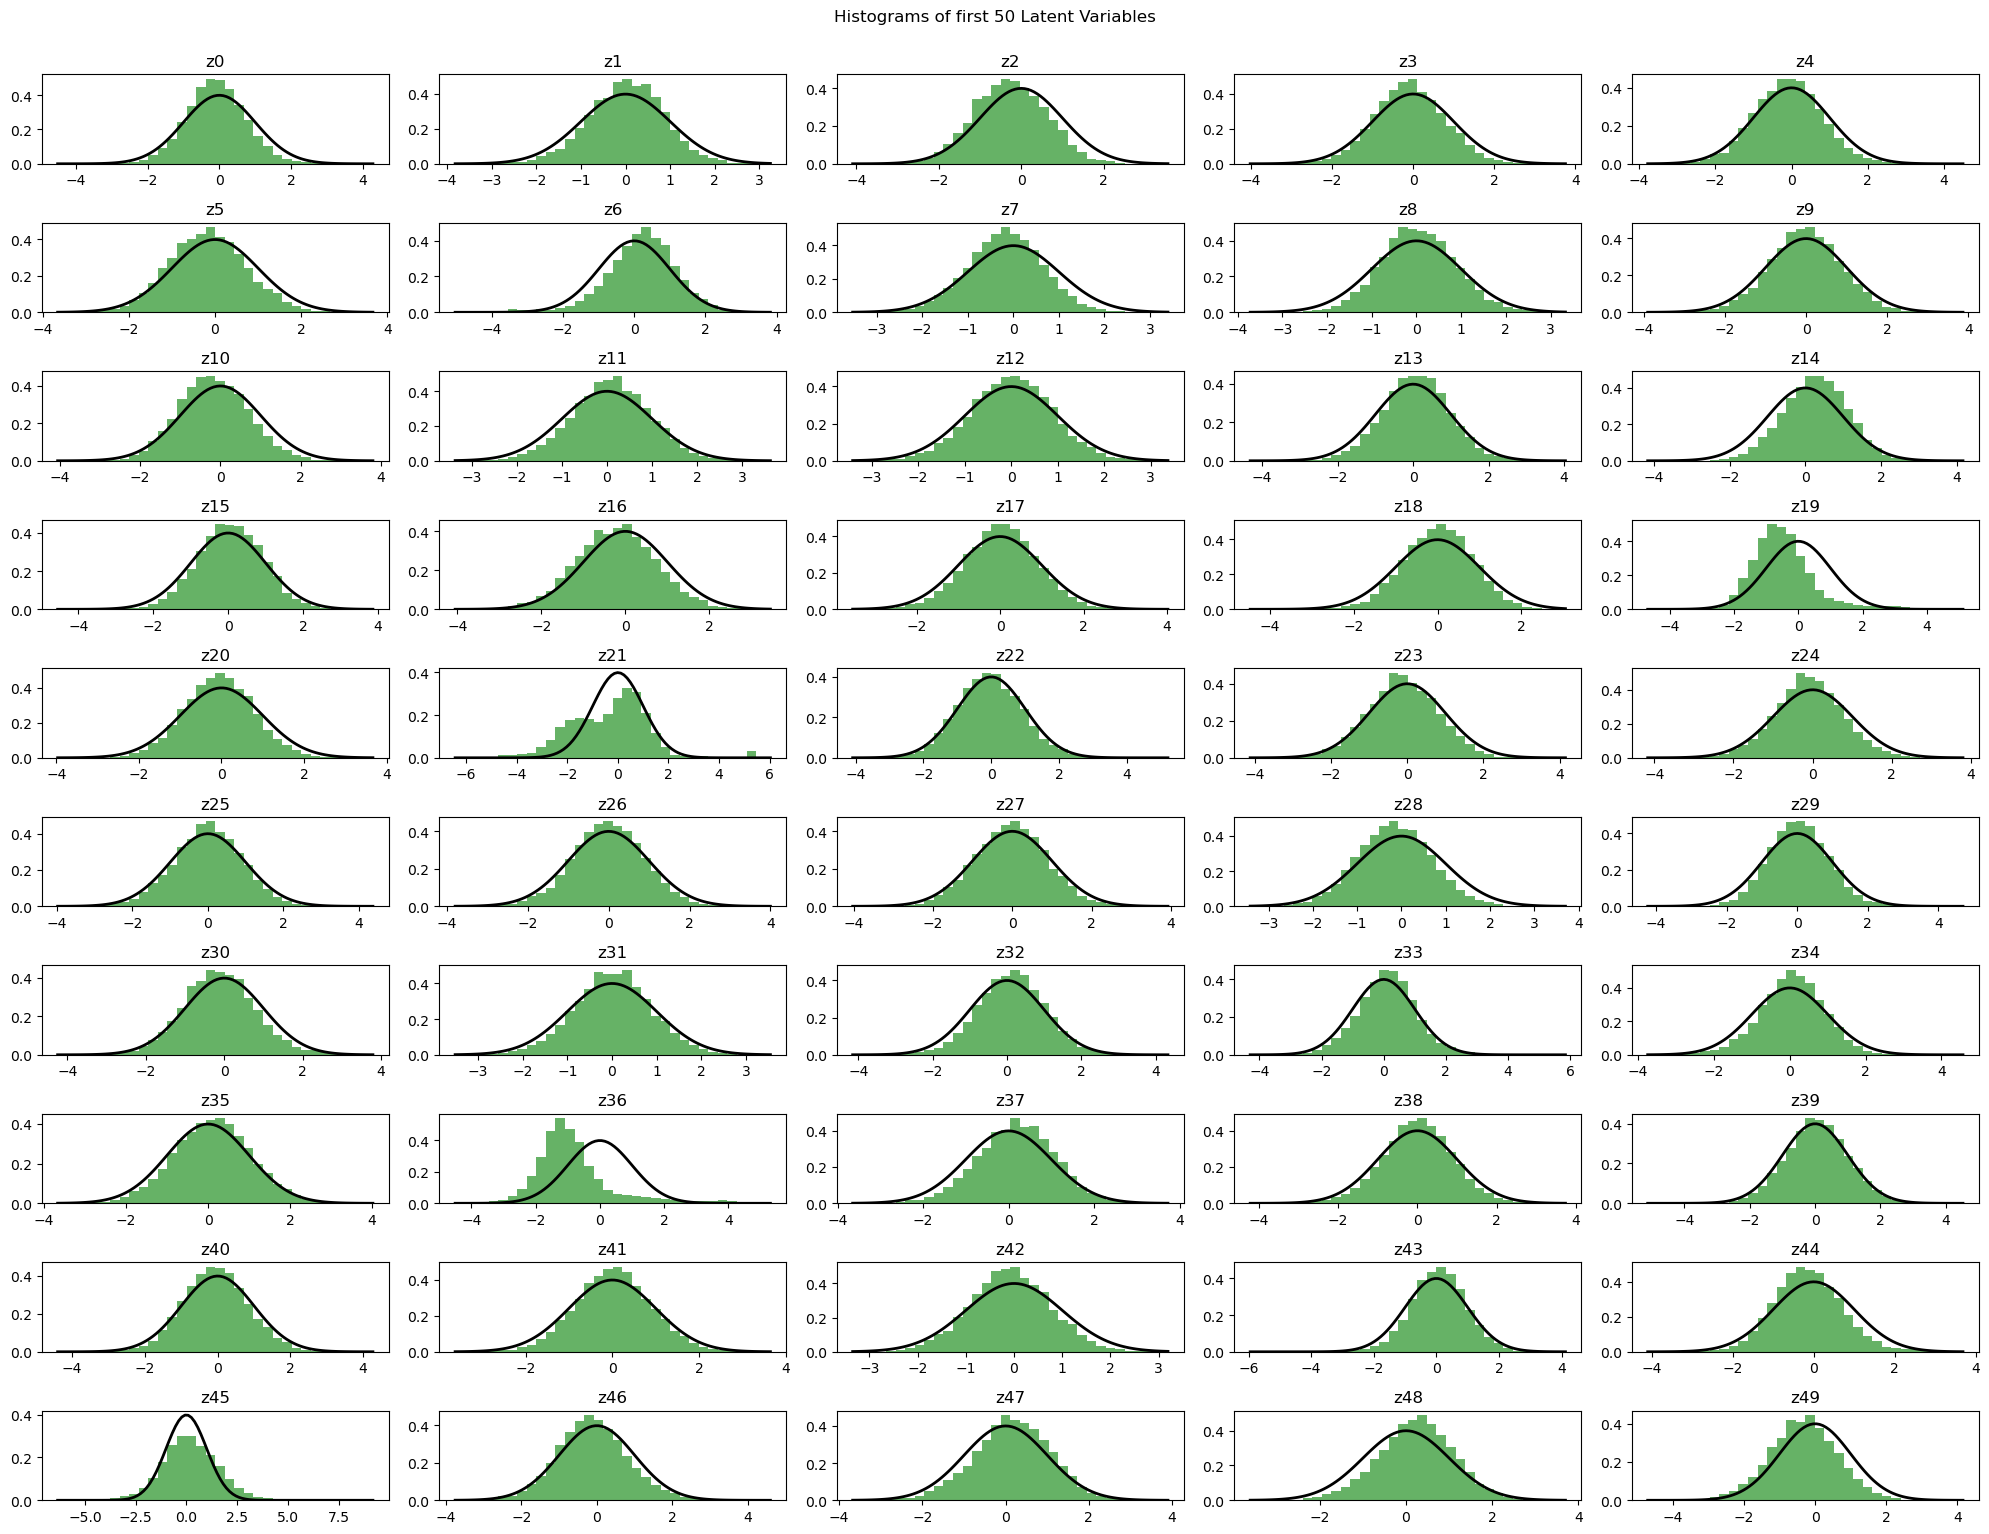

In [311]:
### CHecking if latent codings follow a Gaussian distribution

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import norm, probplot

# For Gaussian check, plot histograms and Q-Q plots of each latent variable
## histogram: show if follow bell curve
##Q-Q plot: should follow straight diagonal line

# for i in range(latent_codings.shape[1]):

#     plt.figure(figsize=(12, 5))
#     print(latent_codings[:, i].shape)
#     # Histogram
#     plt.subplot(1, 2, 1)
#     plt.hist(latent_codings[:, i], bins=30, density=True, alpha=0.6, color='g')
#     # Plot Gaussian curve
#     xmin, xmax = plt.xlim()
#     x = np.linspace(xmin, xmax, 100)
#     p = norm.pdf(x, 0, 1)
#     plt.plot(x, p, 'k', linewidth=2)
#     plt.title(f'Histogram of Latent Variable {i}')
    
#     # Q-Q plot
#     plt.subplot(1, 2, 2)
#     probplot(latent_codings[:, i], dist="norm", plot=plt)
#     plt.title(f'Q-Q Plot for Latent Variable {i}')
    
#     plt.tight_layout()
#     plt.show()



import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, probplot

# Plot all histograms in a 10x5 grid
plt.figure(figsize=(20, 15))  # Adjust the size to accommodate 10x5 subplots
for i in range(50):
    plt.subplot(10, 5, i+1)
    plt.hist(latent_codings[:, i], bins=30, density=True, alpha=0.6, color='g')
    
    # Plot Gaussian curve
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, 0, 1)
    plt.plot(x, p, 'k', linewidth=2)
    
    plt.title(f'z{i}')  # Label for each latent variable
    plt.tight_layout()
plt.suptitle("Histograms of first 50 Latent Variables", y=1.02)
plt.show()

# Plot all Q-Q plots in a 10x5 grid
# plt.figure(figsize=(20, 15))  # Adjust the size to accommodate 10x5 subplots
# for i in range(latent_codings.shape[1]):
#     plt.subplot(30, 5, i+1)
#     probplot(latent_codings[:, i], dist="norm", plot=plt)
    
#     plt.title(f'z{i}')  # Label for each latent variable
#     plt.tight_layout()
# plt.suptitle("Q-Q Plots of Latent Variables", y=1.02)
# plt.show()




In [312]:
print(f"latent_codings.shape: {latent_codings.shape}")


latent_codings.shape: (8856, 300)


## Checking Reconstructions
Now that we have investigated the distribution, I need to check that it reconstructs inputs well

In [313]:
# num_samples = 10
# indices = np.random.choice(X_val.shape[0], num_samples, replace=False) # randomly get 10 indices
# print(indices)

[6694 5121 6399 7278  927 6528 1141 1200 6503 6796]

In [314]:
### Checking accuracy

# randomly select 10 samples from validation set
num_samples = 10
indices = [6694, 5121, 6399, 7278,  7248, 7098, 1989, 7670, 6503, 6796]
selected_inputs = X_val[indices]

reconstructed_outputs = variational_decoder.predict(latent_codings)

277/277 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step


In [315]:
# get matching 10 reconstructed samples
selected_outputs = reconstructed_outputs[indices]
selected_outputs.shape

(10, 12001)

In [316]:
# split inputs and outputs into features
# Split the input and output vectors into four parts:
def split_features(data):
    DNAm = data[:, 0:4000]       # DNAm
    K9 = data[:, 4000:8000]      # K9
    K27 = data[:, 8000:12000]    # K27
    expression = data[:, 12000]  # expression
    return DNAm, K9, K27, expression

input_DNAm, input_K9, input_K27, input_expr = split_features(selected_inputs)
output_DNAm, output_K9, output_K27, output_expr = split_features(selected_outputs)


Sample 1: Input vs Output


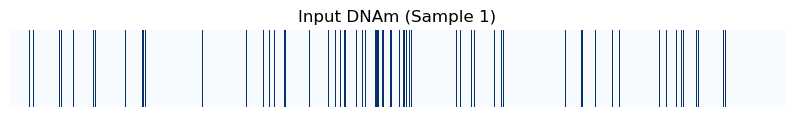

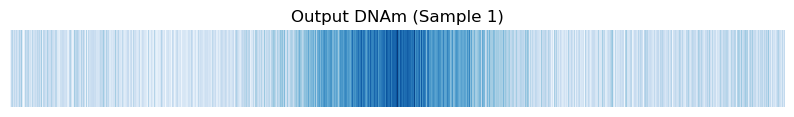

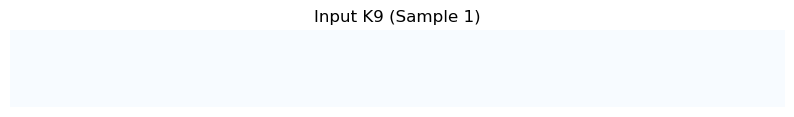

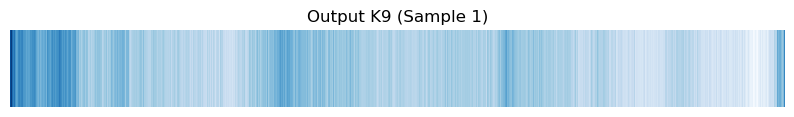

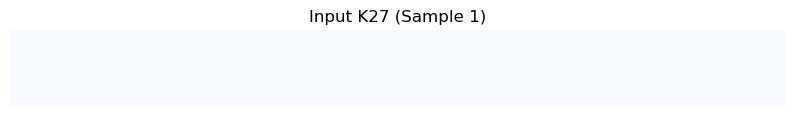

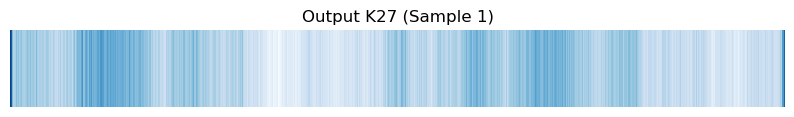

Input Expression: 1.0
Output Expression: 0.7019078135490417
--------------------------------------------------
Sample 2: Input vs Output


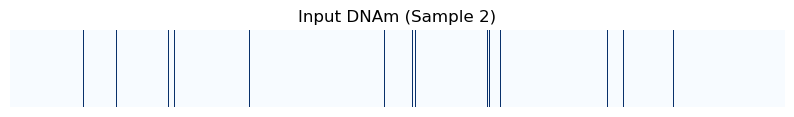

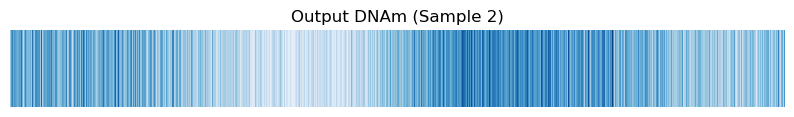

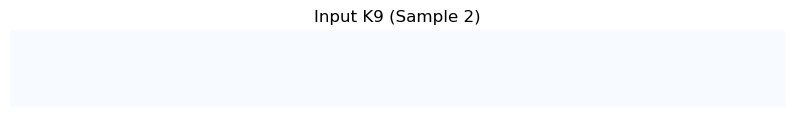

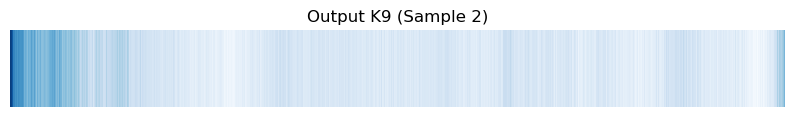

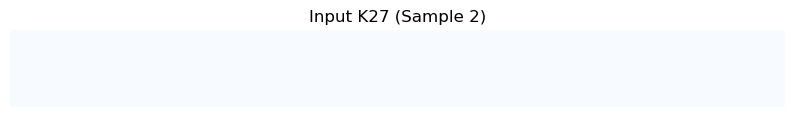

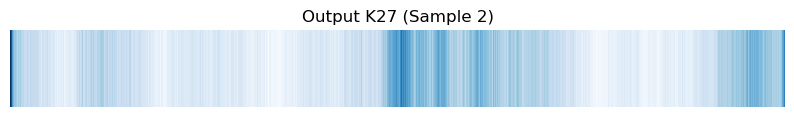

Input Expression: 0.0
Output Expression: 0.42445507645606995
--------------------------------------------------
Sample 3: Input vs Output


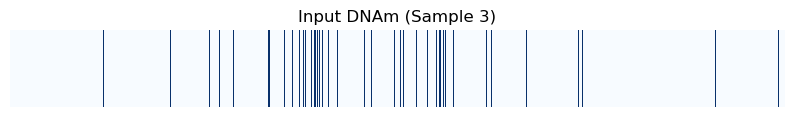

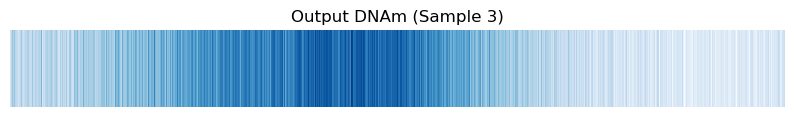

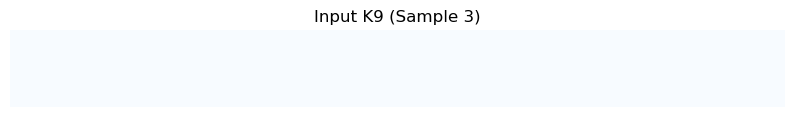

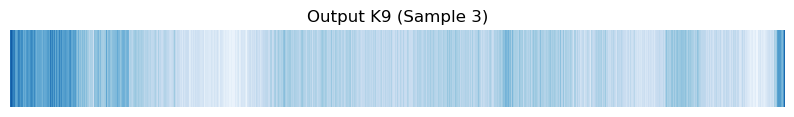

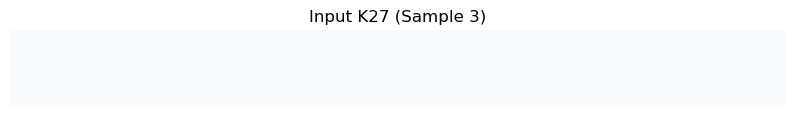

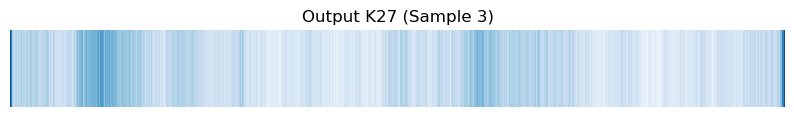

Input Expression: 1.0
Output Expression: 0.6628534197807312
--------------------------------------------------
Sample 4: Input vs Output


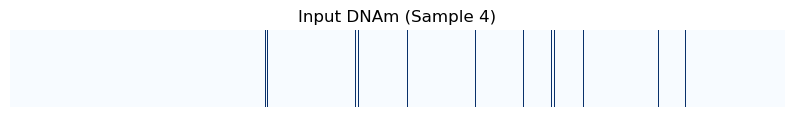

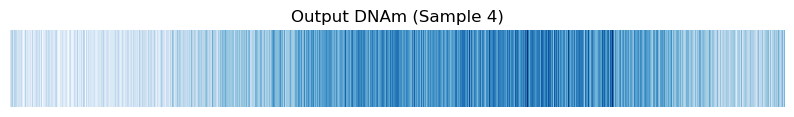

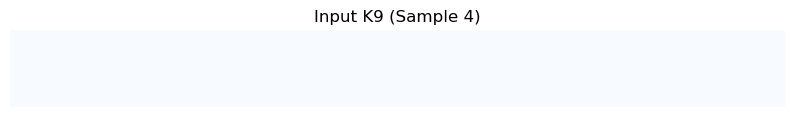

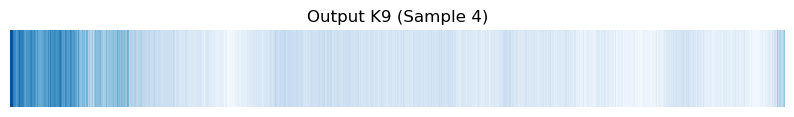

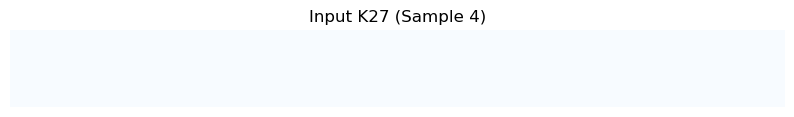

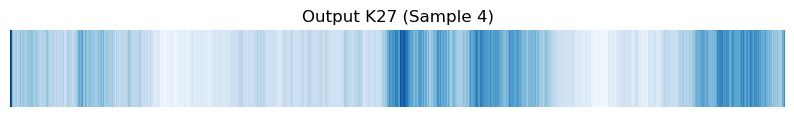

Input Expression: 0.0
Output Expression: 0.4301582872867584
--------------------------------------------------
Sample 5: Input vs Output


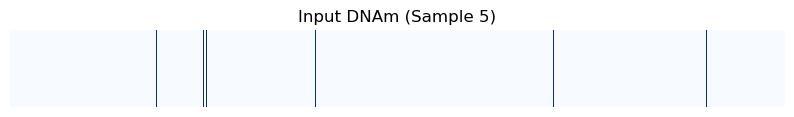

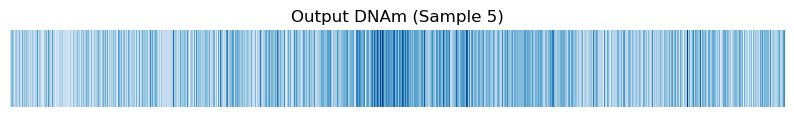

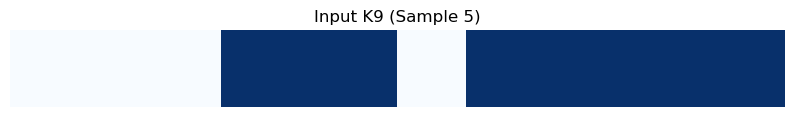

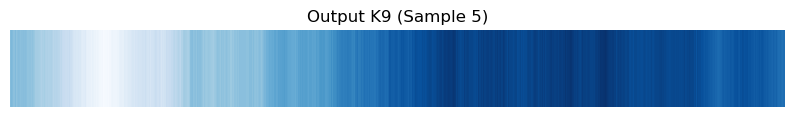

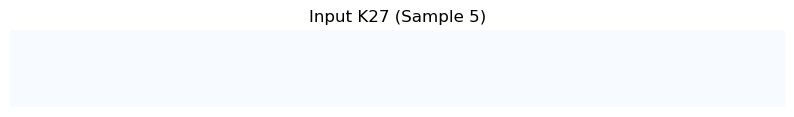

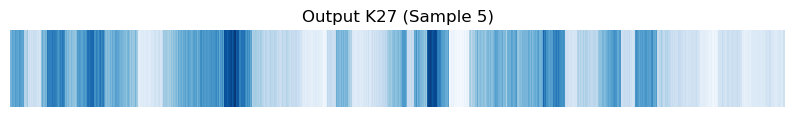

Input Expression: 0.0
Output Expression: 0.3443830907344818
--------------------------------------------------
Sample 6: Input vs Output


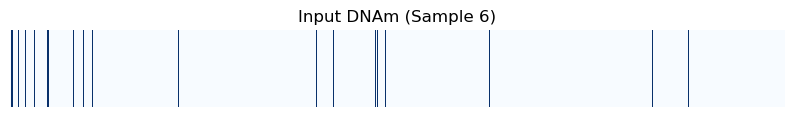

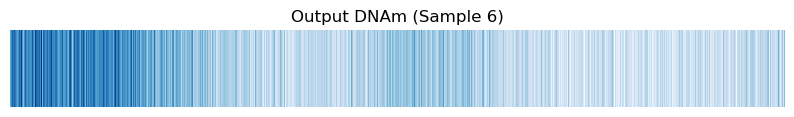

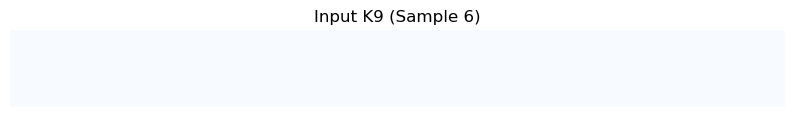

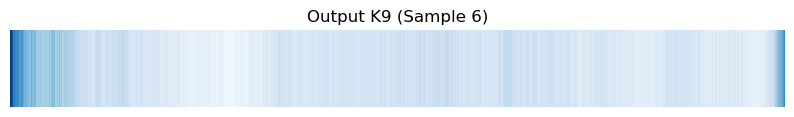

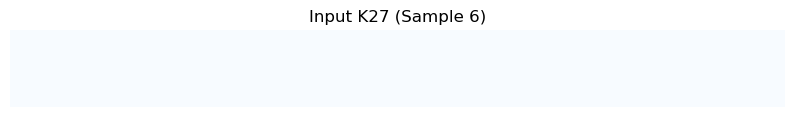

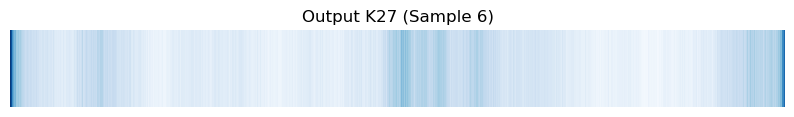

Input Expression: 0.0
Output Expression: 0.4350453019142151
--------------------------------------------------
Sample 7: Input vs Output


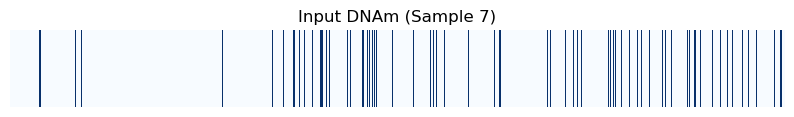

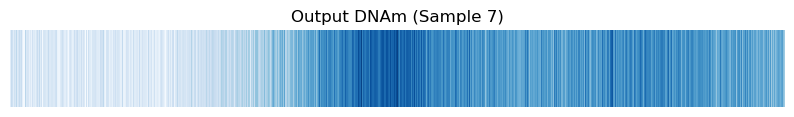

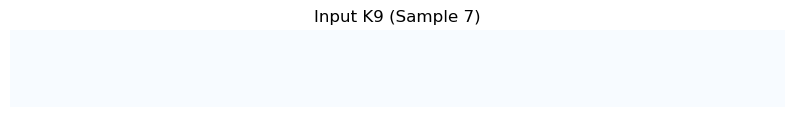

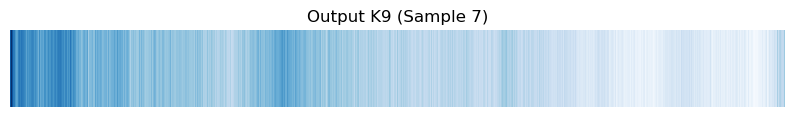

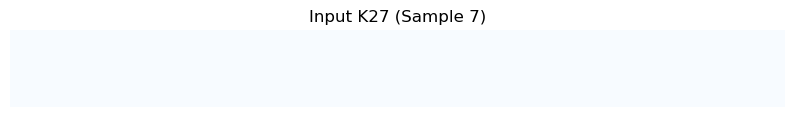

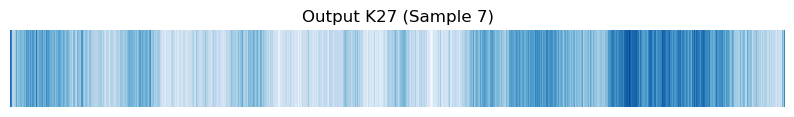

Input Expression: 1.0
Output Expression: 0.6840246915817261
--------------------------------------------------
Sample 8: Input vs Output


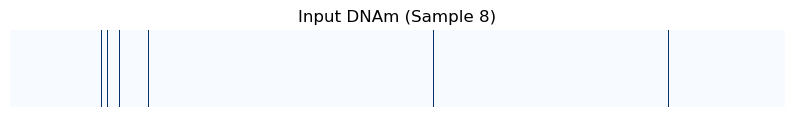

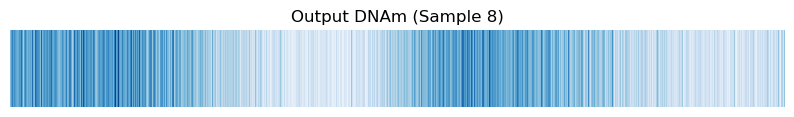

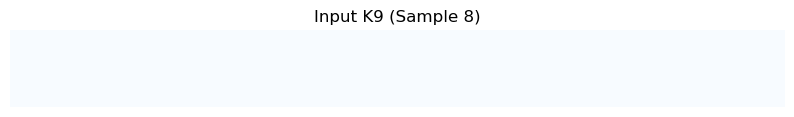

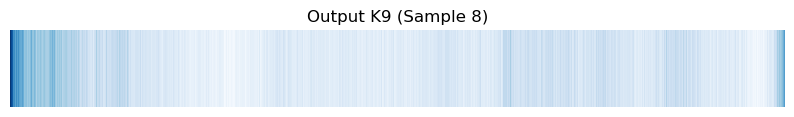

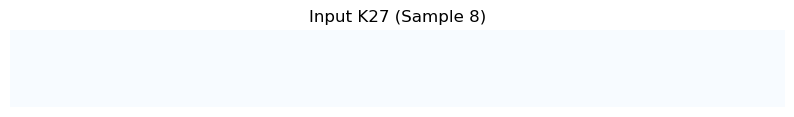

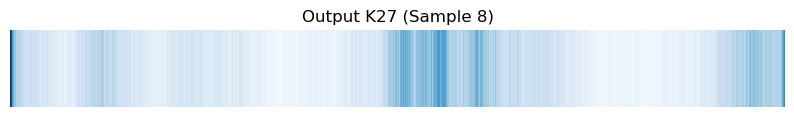

Input Expression: 1.0
Output Expression: 0.3787768483161926
--------------------------------------------------
Sample 9: Input vs Output


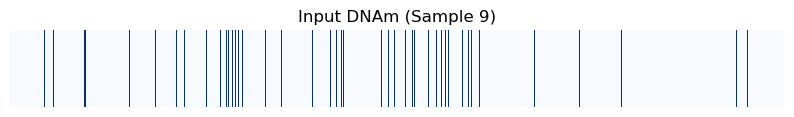

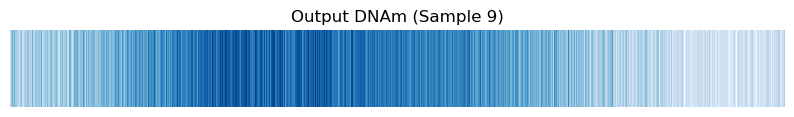

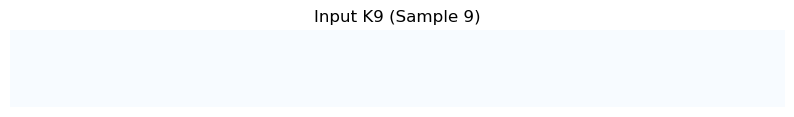

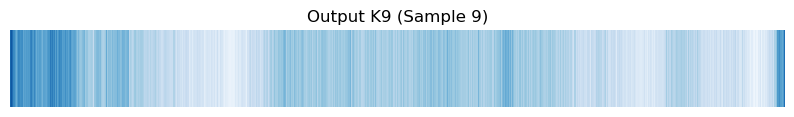

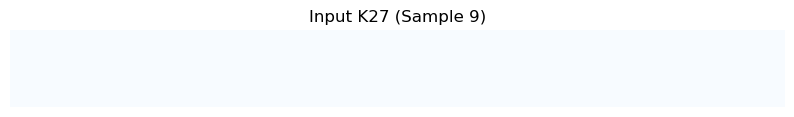

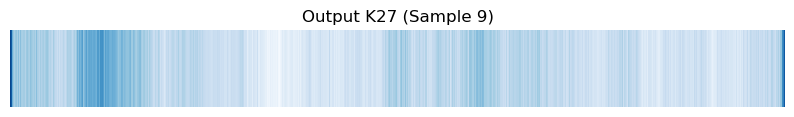

Input Expression: 1.0
Output Expression: 0.615571141242981
--------------------------------------------------
Sample 10: Input vs Output


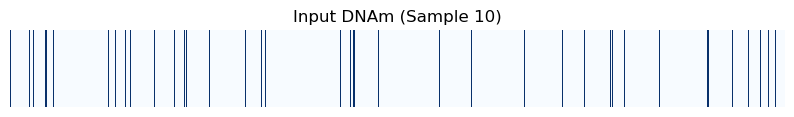

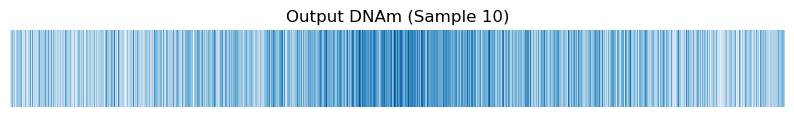

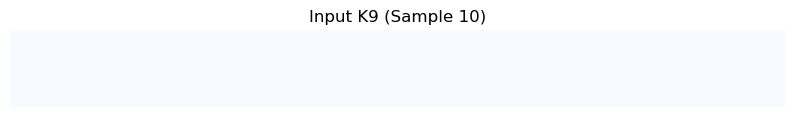

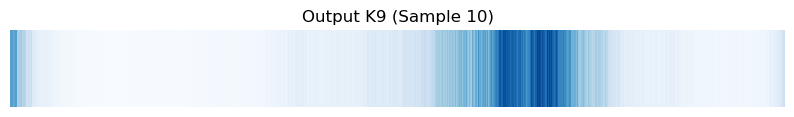

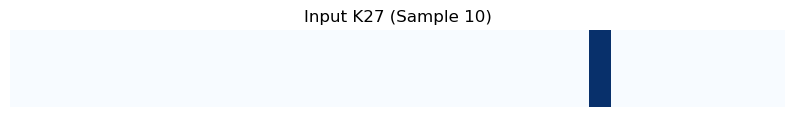

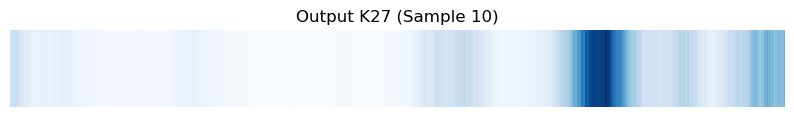

Input Expression: 1.0
Output Expression: 0.4848584234714508
--------------------------------------------------


In [317]:
import matplotlib.pyplot as plt
import seaborn as sns

# visualise bar (white for 0 and blue for 1)
def plot_binary_bar(binary_vector, title):
    plt.figure(figsize=(10, 1))
    sns.heatmap([binary_vector], cmap="Blues", cbar=False, xticklabels=False, yticklabels=False)
    plt.title(title)
    plt.show()

# Visualize 10 samples, comparing input vs output
for i in range(num_samples):
    print(f"Sample {i+1}: Input vs Output")
    
    # DNAm
    plot_binary_bar(input_DNAm[i], f"Input DNAm (Sample {i+1})")
    plot_binary_bar(output_DNAm[i], f"Output DNAm (Sample {i+1})")
    
    # K9
    plot_binary_bar(input_K9[i], f"Input K9 (Sample {i+1})")
    plot_binary_bar(output_K9[i], f"Output K9 (Sample {i+1})")
    
    # K27
    plot_binary_bar(input_K27[i], f"Input K27 (Sample {i+1})")
    plot_binary_bar(output_K27[i], f"Output K27 (Sample {i+1})")
    
    # Expression (single value, so we'll just print it)
    print(f"Input Expression: {input_expr[i]}")
    print(f"Output Expression: {output_expr[i]}")
    print("-" * 50)


In [318]:
# threshold = 0.3
# binary_reconstructions = (selected_outputs >= threshold).astype(int)
# print(binary_reconstructions)
# print(selected_outputs)


# input_DNAm_bin, input_K9_bin, input_K27_bin, input_expr_bin = split_features(selected_inputs)
# output_DNAm_bin, output_K9_bin, output_K27_bin, output_expr_bin = split_features(binary_reconstructions)


In [319]:
# over_threshold = selected_outputs[selected_outputs > 0.1]

# print("Values in selected_outputs greater than 0.5:")
# print(over_threshold)

In [320]:
# # Visualize 10 samples, comparing input vs output
# for i in range(num_samples):
#     print(f"Sample {i+1}: Input vs Output")
    
#     # DNAm
#     plot_binary_bar(input_DNAm_bin[i], f"Input DNAm (Sample {i+1})")
#     plot_binary_bar(output_DNAm_bin[i], f"Output DNAm (Sample {i+1})")
    
#     # K9
#     plot_binary_bar(input_K9_bin[i], f"Input K9 (Sample {i+1})")
#     plot_binary_bar(output_K9_bin[i], f"Output K9 (Sample {i+1})")
    
#     # K27
#     plot_binary_bar(input_K27_bin[i], f"Input K27 (Sample {i+1})")
#     plot_binary_bar(output_K27_bin[i], f"Output K27 (Sample {i+1})")
    
#     # Expression (single value, so we'll just print it)
#     print(f"Input Expression: {input_expr_bin[i]}")
#     print(f"Output Expression: {output_expr_bin[i]}")
#     print("-" * 50)

In [321]:
# print(X_train.shape)
# print(X_train[:,-1])
# print(np.mean(X_train[:,-1]))
# print(np.mean(X_train[:,:]))

# ### MODEL IS JUST PREDICTING THE MEAN

In [322]:
# print(selected_outputs[:,-1])
# print(np.mean(selected_outputs[:,-1]))


In [323]:
# DNAm_mean = (np.mean(X_train[:,:4000]))
# K9_mean = (np.mean(X_train[:,4000:8000]))
# K27_mean = (np.mean(X_train[:,8000:12000]))
# print(DNAm_mean)
# print(K9_mean)
# print(K27_mean)

In [324]:
DNAm_recon = (selected_outputs[:, :4000])
K9_recon = (selected_outputs[:, 4000:8000])
K27_recon = (selected_outputs[:, 8000:12000])
exp_recon = (selected_outputs[:, -1])

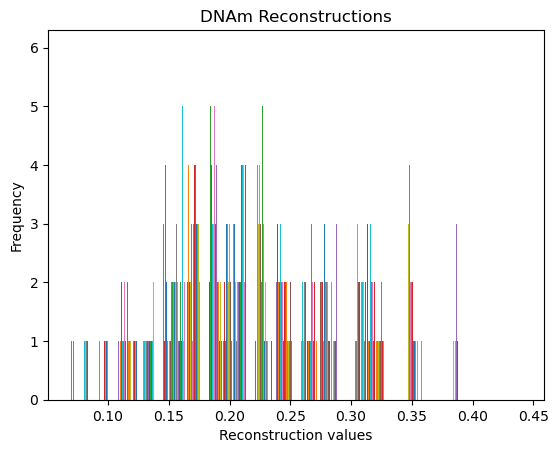

In [325]:
plt.hist(DNAm_recon)
plt.title('DNAm Reconstructions')
plt.xlabel('Reconstruction values')
plt.ylabel("Frequency")
plt.show()

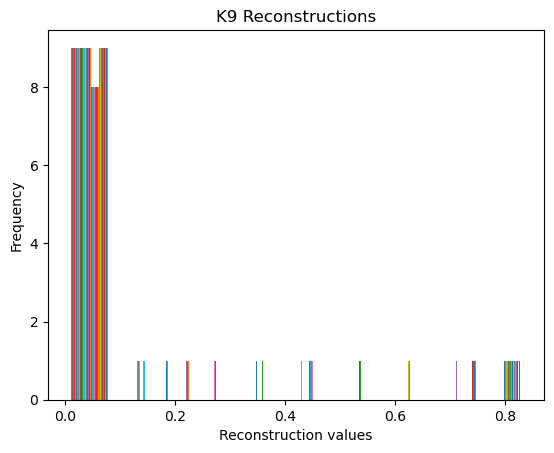

In [326]:
plt.hist(K9_recon)
plt.title('K9 Reconstructions')
plt.xlabel('Reconstruction values')
plt.ylabel("Frequency")
plt.show()

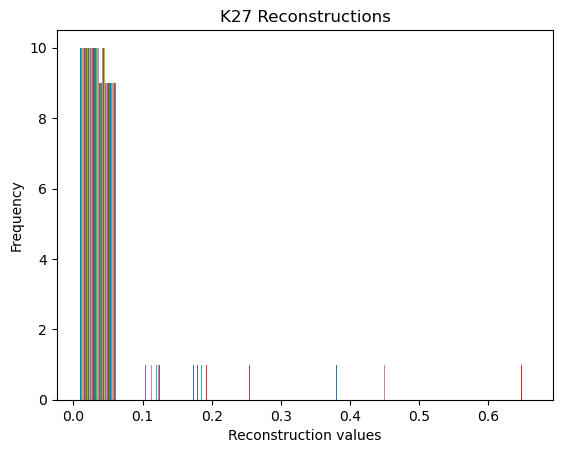

In [327]:
plt.hist(K27_recon)
plt.title('K27 Reconstructions')
plt.xlabel('Reconstruction values')
plt.ylabel("Frequency")
plt.show()

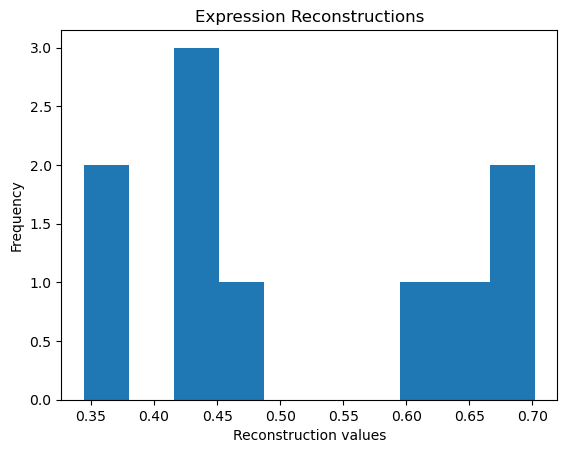

In [328]:
plt.hist(exp_recon)
plt.title('Expression Reconstructions')
plt.xlabel('Reconstruction values')
plt.ylabel("Frequency")
plt.show()

### Checking classification accuracy

In [329]:
### Expression
import numpy as np
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, precision_score, recall_score


y_pred = variational_ae.predict(X_val)
y_pred = np.array(y_pred)
print(f"y_pred shape: {y_pred.shape}")
# get expression from y_true and y_pred (X_val and decoder output)
y_true_expr = X_val[:, -1]  
y_pred_expr = y_pred[:,:, -1].T

# Convert predictions to binary 
threshold = 0.5
y_pred_expr_binary = (y_pred_expr >= threshold).astype(int)

# Calculate accuracy and MSE for the expression value
expr_accuracy = accuracy_score(y_true_expr, y_pred_expr_binary)
expr_mse = mean_squared_error(y_true_expr, y_pred_expr)
expr_f1 = f1_score(y_true_expr, y_pred_expr_binary)
expr_precision = precision_score(y_true_expr, y_pred_expr_binary)
expr_recall = recall_score(y_true_expr, y_pred_expr_binary)

print(f"Expression Accuracy: {expr_accuracy:.4f}")
print(f"Expression Mean Squared Error: {expr_mse:.4f}")
print(f"Expression F1 Score: {expr_f1:.4f}")
print(f"Expression Precision: {expr_precision:.4f}")
print(f"Expression Recall: {expr_recall:.4f}")


277/277 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step
y_pred shape: (1, 8856, 12001)
Expression Accuracy: 0.7366
Expression Mean Squared Error: 0.2014
Expression F1 Score: 0.7058
Expression Precision: 0.8031
Expression Recall: 0.6295


In [330]:
### Training metrics

y_pred_train = variational_ae.predict(X_train)
y_pred_train = np.array(y_pred_train)
# get expression from y_true and y_pred (X_val and decoder output)
y_true_expr_train = X_train[:, -1]  
y_pred_expr_train = y_pred_train[:,:, -1].T

# Convert predictions to binary 
threshold = 0.5
y_pred_expr_binary_train = (y_pred_expr_train >= threshold).astype(int)

# Calculate accuracy and MSE for the expression value
expr_accuracy_train = accuracy_score(y_true_expr_train, y_pred_expr_binary_train)
expr_mse_train = mean_squared_error(y_true_expr_train, y_pred_expr_train)
expr_f1_train = f1_score(y_true_expr_train, y_pred_expr_binary_train)
expr_precision_train = precision_score(y_true_expr_train, y_pred_expr_binary_train)
expr_recall_train = recall_score(y_true_expr_train, y_pred_expr_binary_train)

print(f"Expression Accuracy: {expr_accuracy_train:.4f}")
print(f"Expression Mean Squared Error: {expr_mse_train:.4f}")
print(f"Expression F1 Score: {expr_f1_train:.4f}")
print(f"Expression Precision: {expr_precision_train:.4f}")
print(f"Expression Recall: {expr_recall_train:.4f}")


1107/1107 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step
Expression Accuracy: 0.7336
Expression Mean Squared Error: 0.1999
Expression F1 Score: 0.7037
Expression Precision: 0.7917
Expression Recall: 0.6334


In [331]:
# MSE against original outputs
# 
# from sklearn.metrics import mean_squared_error

threshold = 0.5

y_pred_expr_binary = (y_pred_expr >= threshold).astype(int)
print(y_pred_expr_binary.shape)

# Section 1: DNAm (first 4000 values)
DNAm_true = X_val[:, :4000]
DNAm_pred = y_pred_expr_binary[:, :4000]
DNAm_true_counts = np.sum(DNAm_true, axis=1)
DNAm_pred_counts = np.sum(DNAm_pred, axis=1)

# Section 2: K9 (4000 to 8000)
K9_true = X_val[:, 4000:8000]
K9_pred = y_pred_expr_binary[:, 4000:8000]
K9_true_counts = np.sum(K9_true, axis=1)
K9_pred_counts = np.sum(K9_pred, axis=1)

# Section 3: K27 (8000 to 12000)
K27_true = X_val[:, 8000:12000]
K27_pred = y_pred_expr_binary[:, 8000:12000]
K27_true_counts = np.sum(K27_true, axis=1)
K27_pred_counts = np.sum(K27_pred, axis=1)

# Calculate MSE for DNAm section
mse_DNAm = mean_squared_error(DNAm_true_counts, DNAm_pred_counts)
print(f"MSE for DNAm section: {mse_DNAm:.4f}")

# Calculate MSE for K9 section
mse_K9 = mean_squared_error(K9_true_counts, K9_pred_counts)
print(f"MSE for K9 section: {mse_K9:.4f}")

# Calculate MSE for K27 section
mse_K27 = mean_squared_error(K27_true_counts, K27_pred_counts)
print(f"MSE for K27 section: {mse_K27:.4f}")

(8856, 1)
MSE for DNAm section: 31849.8435
MSE for K9 section: 262771.3624
MSE for K27 section: 35124.8199


In [332]:
from sklearn.metrics import mean_squared_error
y_pred = np.squeeze(y_pred)  # Removes the extra batch dimension
# Section 1: DNAm (first 4000 values)
DNAm_true = X_val[:, :4000]  # True values for DNAm
DNAm_pred = y_pred[:, :4000]  # Predicted probabilities for DNAm

print(DNAm_true.shape)
print(DNAm_pred.shape)

# Section 2: K9 (4000 to 8000)
K9_true = X_val[:, 4000:8000]  # True values for K9
K9_pred = y_pred[:, 4000:8000]  # Predicted probabilities for K9

# Section 3: K27 (8000 to 12000)
K27_true = X_val[:, 8000:12000]  # True values for K27
K27_pred = y_pred[:, 8000:12000]  # Predicted probabilities for K27

# Calculate MSE for each section
mse_DNAm = mean_squared_error(DNAm_true, DNAm_pred)
print(f"MSE for DNAm section: {mse_DNAm:.4f}")

mse_K9 = mean_squared_error(K9_true, K9_pred)
print(f"MSE for K9 section: {mse_K9:.4f}")

mse_K27 = mean_squared_error(K27_true, K27_pred)
print(f"MSE for K27 section: {mse_K27:.4f}")


(8856, 4000)
(8856, 4000)
MSE for DNAm section: 0.0626
MSE for K9 section: 0.0054
MSE for K27 section: 0.0060
